# IMPORT

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import time
import math
from pylab import plot, show, savefig, xlim, figure, hold, ylim, legend, boxplot, setp, axes

# METHOD

### Euclidean Distance(For Numpy Array)

In [16]:
def np_euclidean(e1,e2):
    return math.sqrt(math.fsum(list(map(lambda x: x**2 ,e1-e2))))

### Generate Data and Results for each File

In [17]:
def read_all_lines(file) :
    with open(file, 'rt') as fd:
        convert = [e.split() for e in fd.readlines()]
        all_data = []
        all_results = []
        for line in convert:
            data = line
            result = data.pop(-1)
            all_data.append(data)
            all_results.append(result)
            
        float_data = []
        for element in all_data:
            float_data.append([float(e) for e in element])
        float_data = np.array(float_data)
        all_results = np.array(all_results)
        
        normalized_data = []
        for element in float_data:
            mean = math.fsum(element)/len(element)
            std = math.sqrt(sum((element-mean)**2)/(len(element)-1))
            normalized_data.append((element - mean)/std)
        normalized_data = np.array(normalized_data)
        return normalized_data, all_results

### Dynamic Time Warping

In [18]:
def dtw_distance(s1, s2):
    DTW={}

    for i in range(len(s1)):
        DTW[(i, -1)] = float('inf')
    for i in range(len(s2)):
        DTW[(-1, i)] = float('inf')
    DTW[(-1, -1)] = 0

    for i in range(len(s1)):
        for j in range(len(s2)):
            dist= (s1[i]-s2[j])**2
            DTW[(i, j)] = dist + min(DTW[(i-1, j)],DTW[(i, j-1)], DTW[(i-1, j-1)])

    return np.sqrt(DTW[len(s1)-1, len(s2)-1])

### DBA

In [19]:
from __future__ import division
from functools import reduce


__author__ ="Francois Petitjean"

def performDBA(series, n_iterations=10):
    n_series = len(series)
    max_length = reduce(max, map(len, series))

    cost_mat = np.zeros((max_length, max_length))
    delta_mat = np.zeros((max_length, max_length))
    path_mat = np.zeros((max_length, max_length), dtype=np.int8)

    medoid_ind = approximate_medoid_index(series,cost_mat,delta_mat)
    center = series[medoid_ind]

    for i in range(0,n_iterations):
        center = DBA_update(center, series, cost_mat, path_mat, delta_mat)

    return center

def approximate_medoid_index(series,cost_mat,delta_mat):
    if len(series)<=50:
        indices = range(0,len(series))
    else:
        indices = np.random.choice(range(0,len(series)),50,replace=False)

    medoid_ind = -1
    best_ss = 1e20
    for index_candidate in indices:
        candidate = series[index_candidate]
        ss = sum_of_squares(candidate,series,cost_mat,delta_mat)
        if(medoid_ind==-1 or ss<best_ss):
            best_ss = ss
            medoid_ind = index_candidate
    return medoid_ind

def sum_of_squares(s,series,cost_mat,delta_mat):
    return sum(map(lambda t:squared_DTW(s,t,cost_mat,delta_mat),series))

def DTW(s,t,cost_mat,delta_mat):
    return np.sqrt(squared_DTW(s,t,cost_mat,delta_mat))

def squared_DTW(s,t,cost_mat,delta_mat):
    s_len = len(s)
    t_len = len(t)
    length = len(s)
    fill_delta_mat_dtw(s, t, delta_mat)
    cost_mat[0, 0] = delta_mat[0, 0]
    for i in range(1, s_len):
        cost_mat[i, 0] = cost_mat[i-1, 0]+delta_mat[i, 0]

    for j in range(1, t_len):
        cost_mat[0, j] = cost_mat[0, j-1]+delta_mat[0, j]

    for i in range(1, s_len):
        for j in range(1, t_len):
            diag,left,top =cost_mat[i-1, j-1], cost_mat[i, j-1], cost_mat[i-1, j]
            if(diag <=left):
                if(diag<=top):
                    res = diag
                else:
                    res = top
            else:
                if(left<=top):
                    res = left
                else:
                    res = top
            cost_mat[i, j] = res+delta_mat[i, j]
    return cost_mat[s_len-1,t_len-1]

def fill_delta_mat_dtw(center, s, delta_mat):
    slim = delta_mat[:len(center),:len(s)]
    np.subtract.outer(center, s,out=slim)
    np.square(slim, out=slim)

def DBA_update(center, series, cost_mat, path_mat, delta_mat):
    options_argmin = [(-1, -1), (0, -1), (-1, 0)]
    updated_center = np.zeros(center.shape)
    n_elements = np.array(np.zeros(center.shape), dtype=int)
    center_length = len(center)
    for s in series:
        s_len = len(s)
        fill_delta_mat_dtw(center, s, delta_mat)
        cost_mat[0, 0] = delta_mat[0, 0]
        path_mat[0, 0] = -1

        for i in range(1, center_length):
            cost_mat[i, 0] = cost_mat[i-1, 0]+delta_mat[i, 0]
            path_mat[i, 0] = 2

        for j in range(1, s_len):
            cost_mat[0, j] = cost_mat[0, j-1]+delta_mat[0, j]
            path_mat[0, j] = 1

        for i in range(1, center_length):
            for j in range(1, s_len):
                diag,left,top =cost_mat[i-1, j-1], cost_mat[i, j-1], cost_mat[i-1, j]
                if(diag <=left):
                    if(diag<=top):
                        res = diag
                        path_mat[i,j] = 0
                    else:
                        res = top
                        path_mat[i,j] = 2
                else:
                    if(left<=top):
                        res = left
                        path_mat[i,j] = 1
                    else:
                        res = top
                        path_mat[i,j] = 2

                cost_mat[i, j] = res+delta_mat[i, j]

        i = center_length-1
        j = s_len-1

        while(path_mat[i, j] != -1):
            updated_center[i] += s[j]
            n_elements[i] += 1
            move = options_argmin[path_mat[i, j]]
            i += move[0]
            j += move[1]
        assert(i == 0 and j == 0)
        updated_center[i] += s[j]
        n_elements[i] += 1

    return np.divide(updated_center, n_elements)

### Calculate F1 Score

In [20]:
def score(test_data,test_results,mrcp_avg,noise_avg):
    e_results = list()
    TP = 0
    TN = 0
    FP = 0
    FN = 0
    for each_test_data in test_data:
        e_class = None
        min_dist = float('inf')
        for avg in mrcp_avg:
            dist = dtw_distance(each_test_data, avg) 
            if dist < min_dist:
                min_dist = dist
                e_class = 'MRCP'
        for avg in noise_avg:
            dist = dtw_distance(each_test_data, avg) 
            if dist < min_dist:
                min_dist = dist
                e_class = 'Noise'
        e_results.append(e_class)
    e_results = np.array(e_results)
    for i in range(len(test_data)):
        if e_results[i] == 'MRCP' and test_results[i] == 'MRCP' :
            TP += 1
        elif e_results[i] == 'MRCP' and test_results[i] == 'Noise' :
            FP += 1
        elif e_results[i] == 'Noise' and test_results[i] == 'MRCP' :
            FN += 1
        elif e_results[i] == 'Noise' and test_results[i] == 'Noise' :
            TN += 1
    precision = TP/(TP+FP)
    recall = TP/(TP+FN)
    accuracy = (TP+TN)/(TP+TN+FP+FN)*100
    f1_score = (2*precision*recall)/(precision+recall)*100
    return accuracy,f1_score

In [29]:
def box_plot(data,title):
    fig = figure()
    plt.figure(figsize=(30,len(data[0])/3))
    red_square = dict(markerfacecolor='red', marker='D')
    plt.title(title,fontsize=30)
    plt.boxplot(data,flierprops=red_square)
    return fig

# IMPORT DATA

### Generate Data and Results for each File

C:\Users\Suphattarawanich.Top\Anaconda3\lib\site-packages\matplotlib\pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<Figure size 432x288 with 0 Axes>

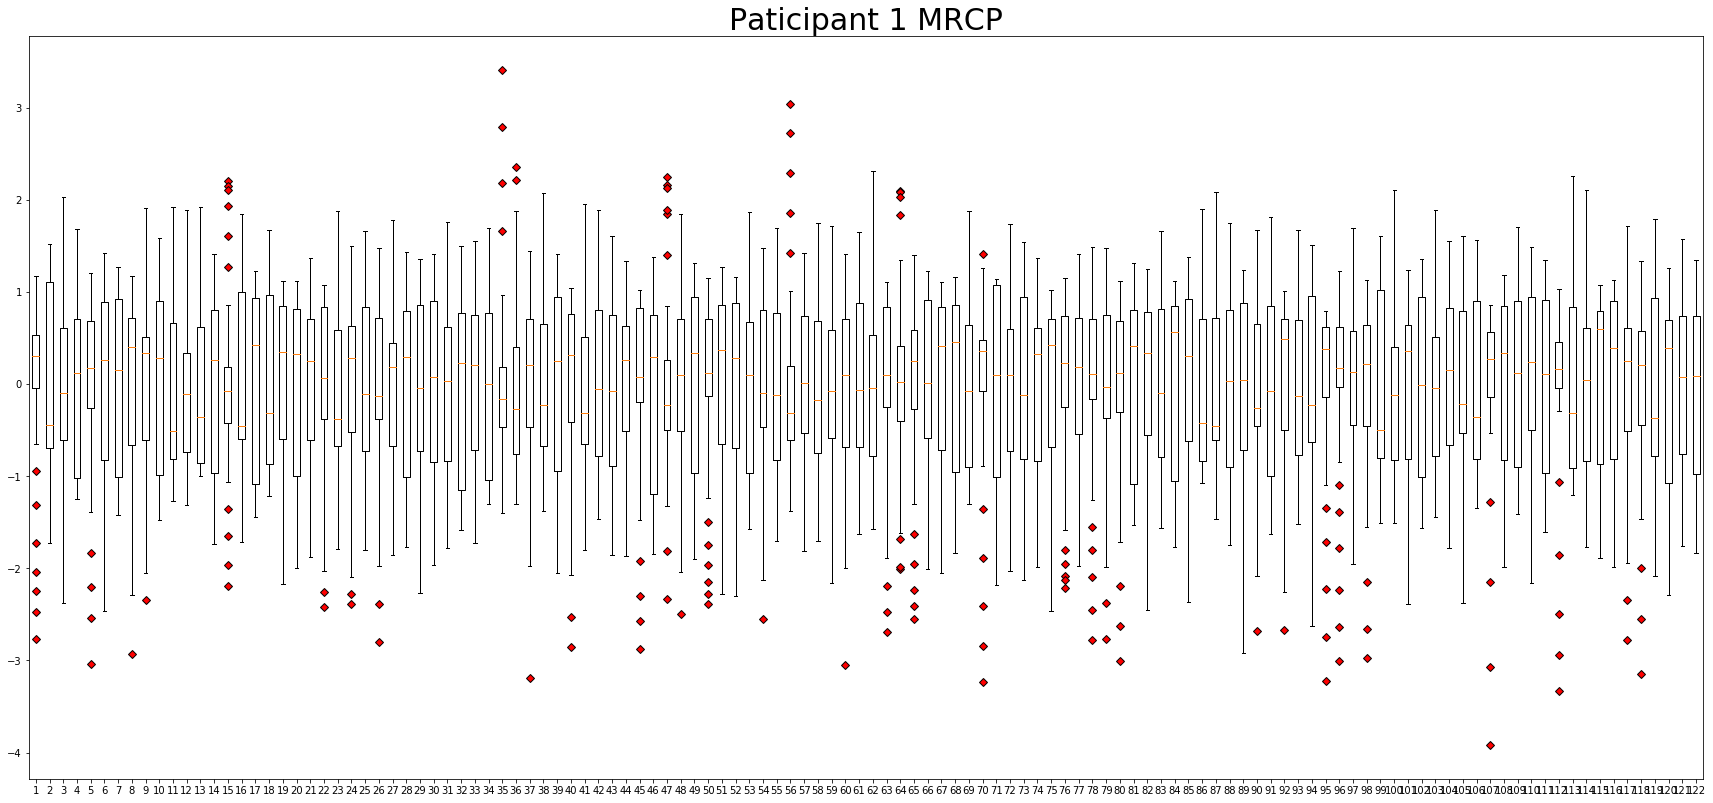

<Figure size 432x288 with 0 Axes>

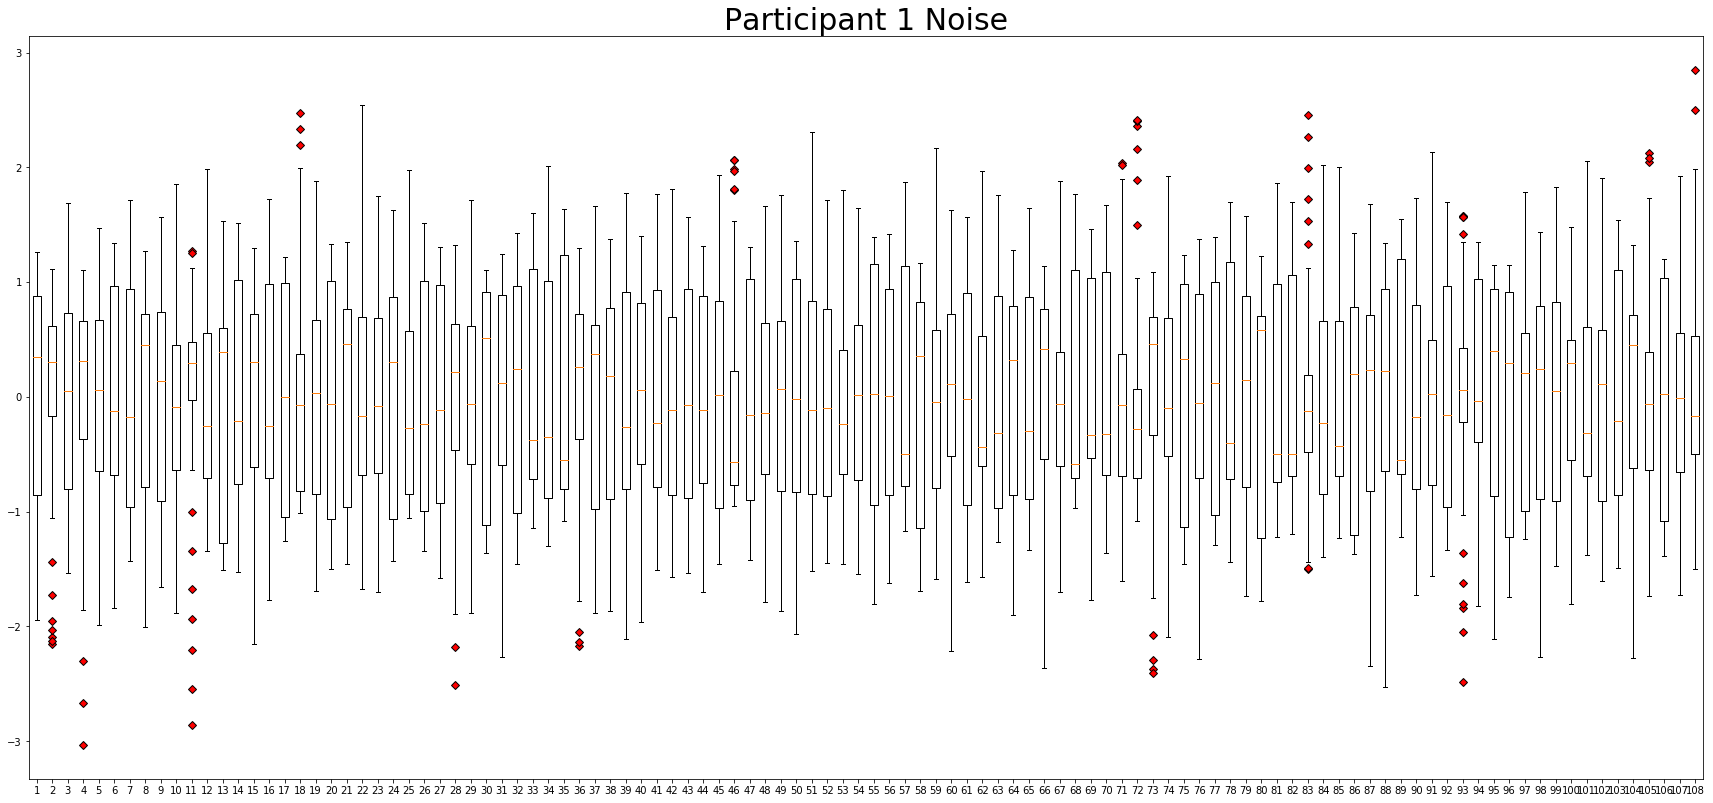

<Figure size 432x288 with 0 Axes>

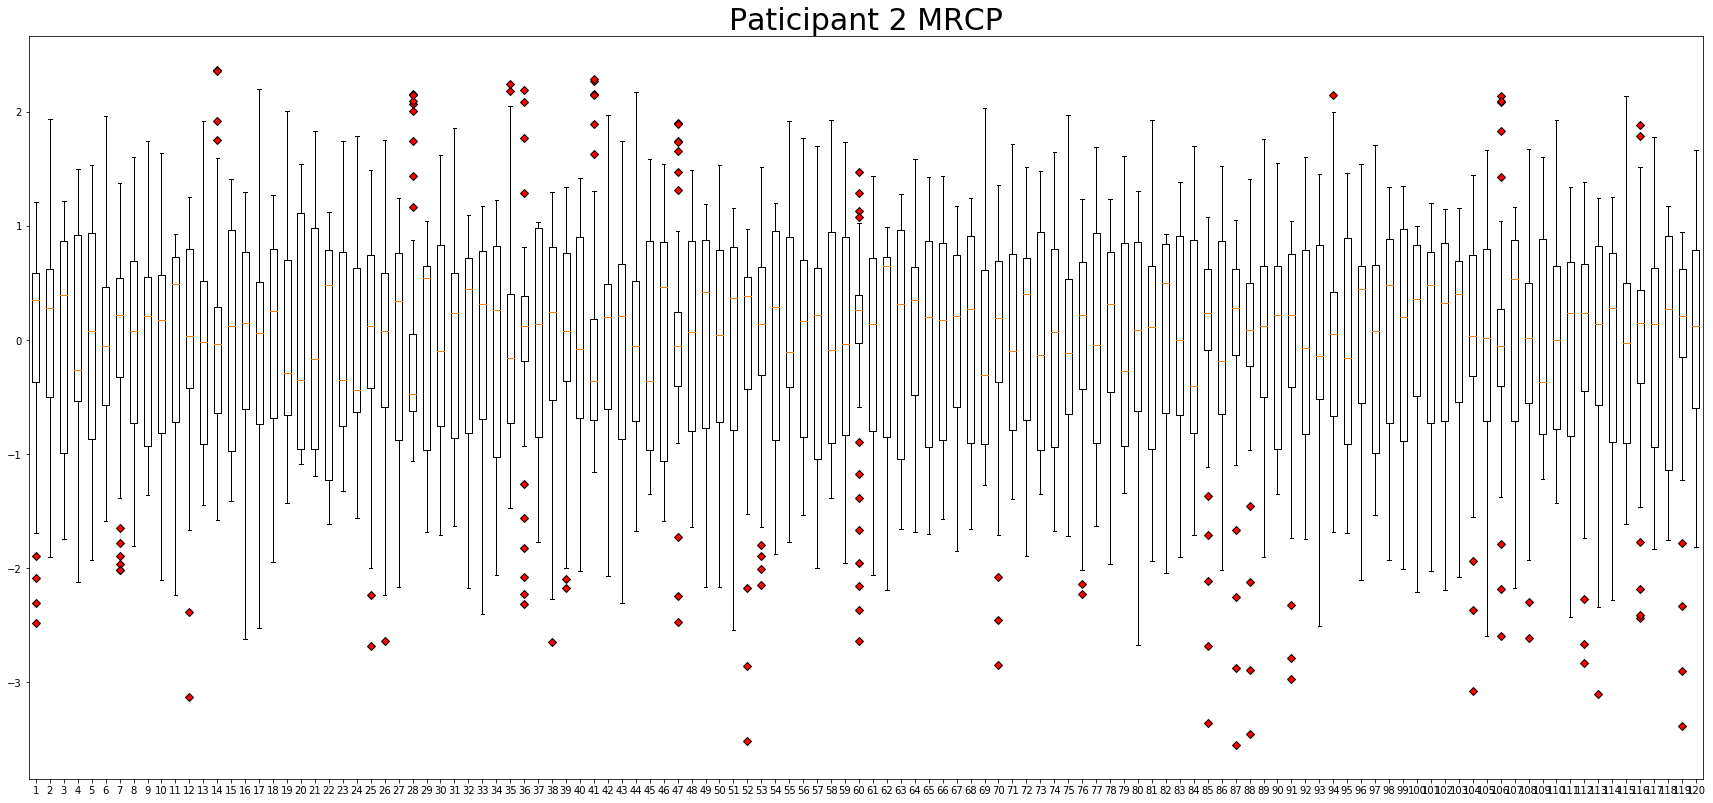

<Figure size 432x288 with 0 Axes>

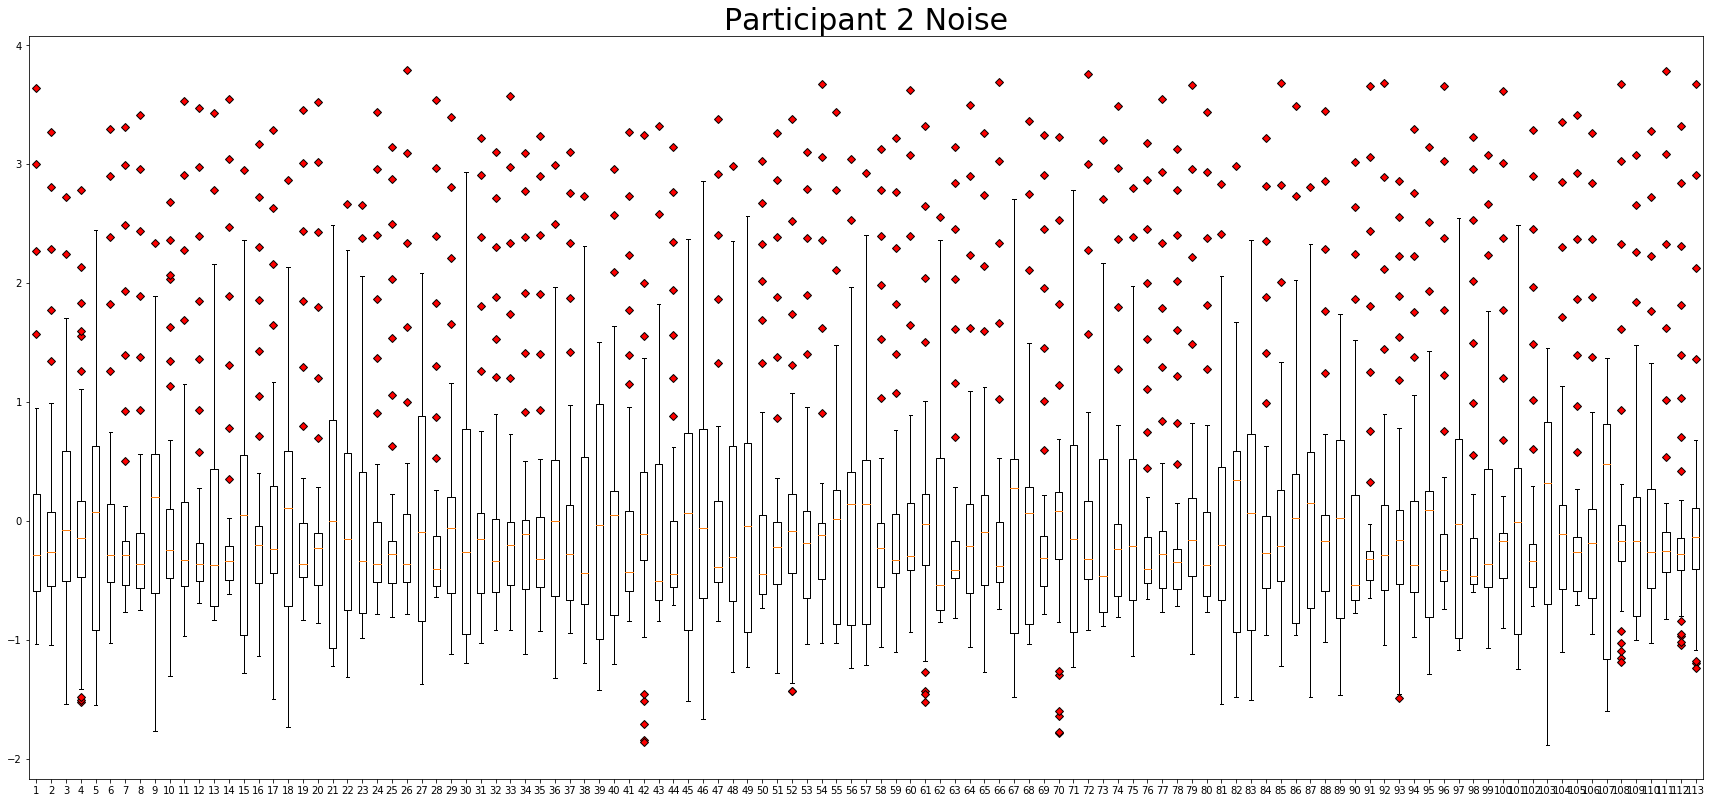

<Figure size 432x288 with 0 Axes>

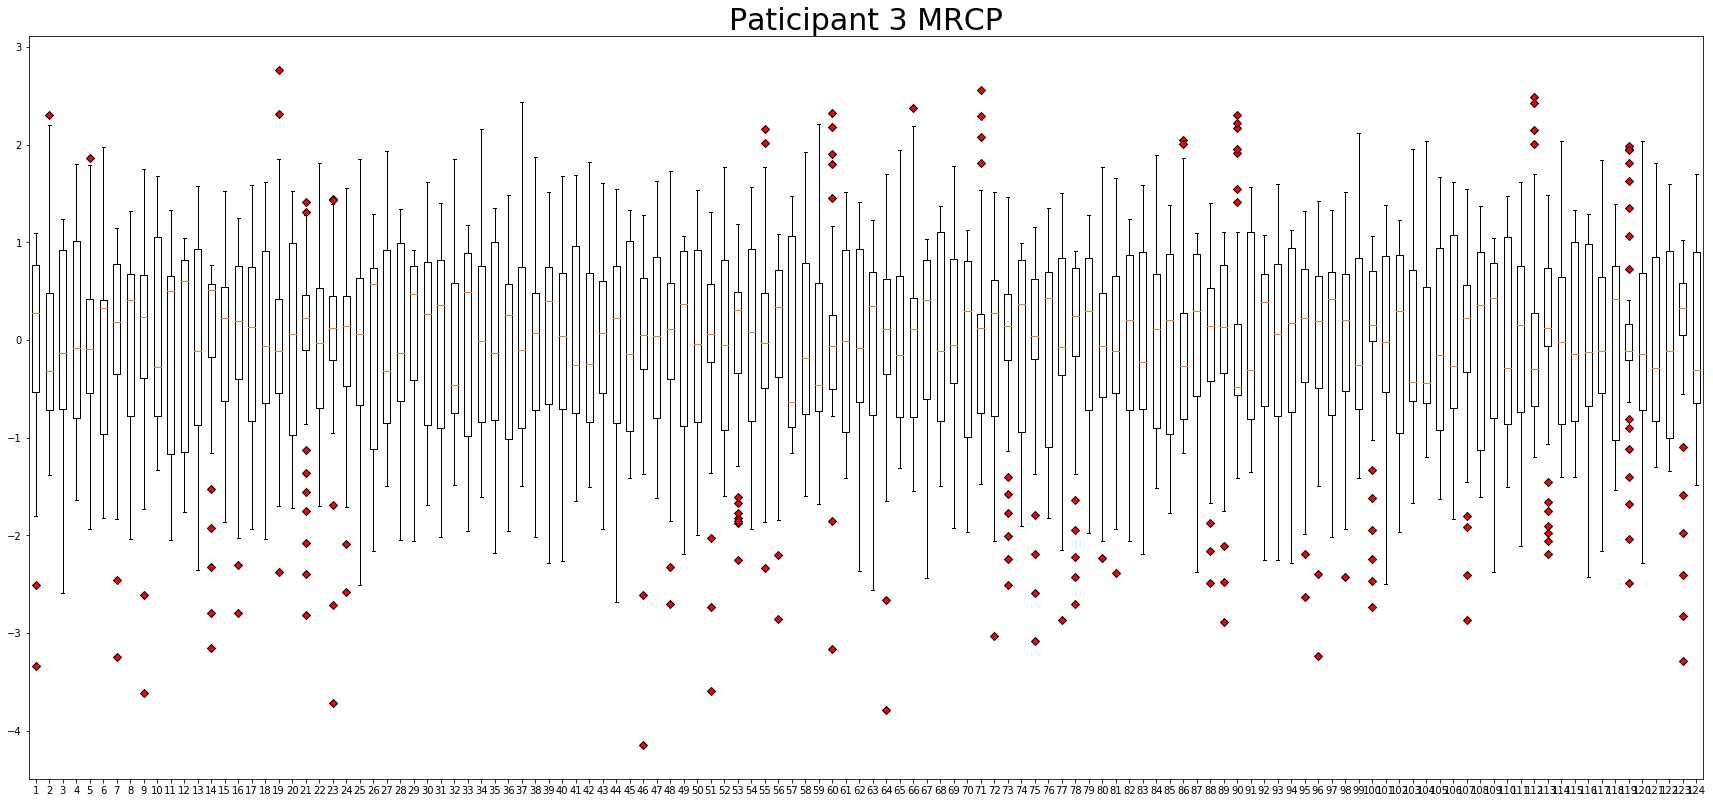

<Figure size 432x288 with 0 Axes>

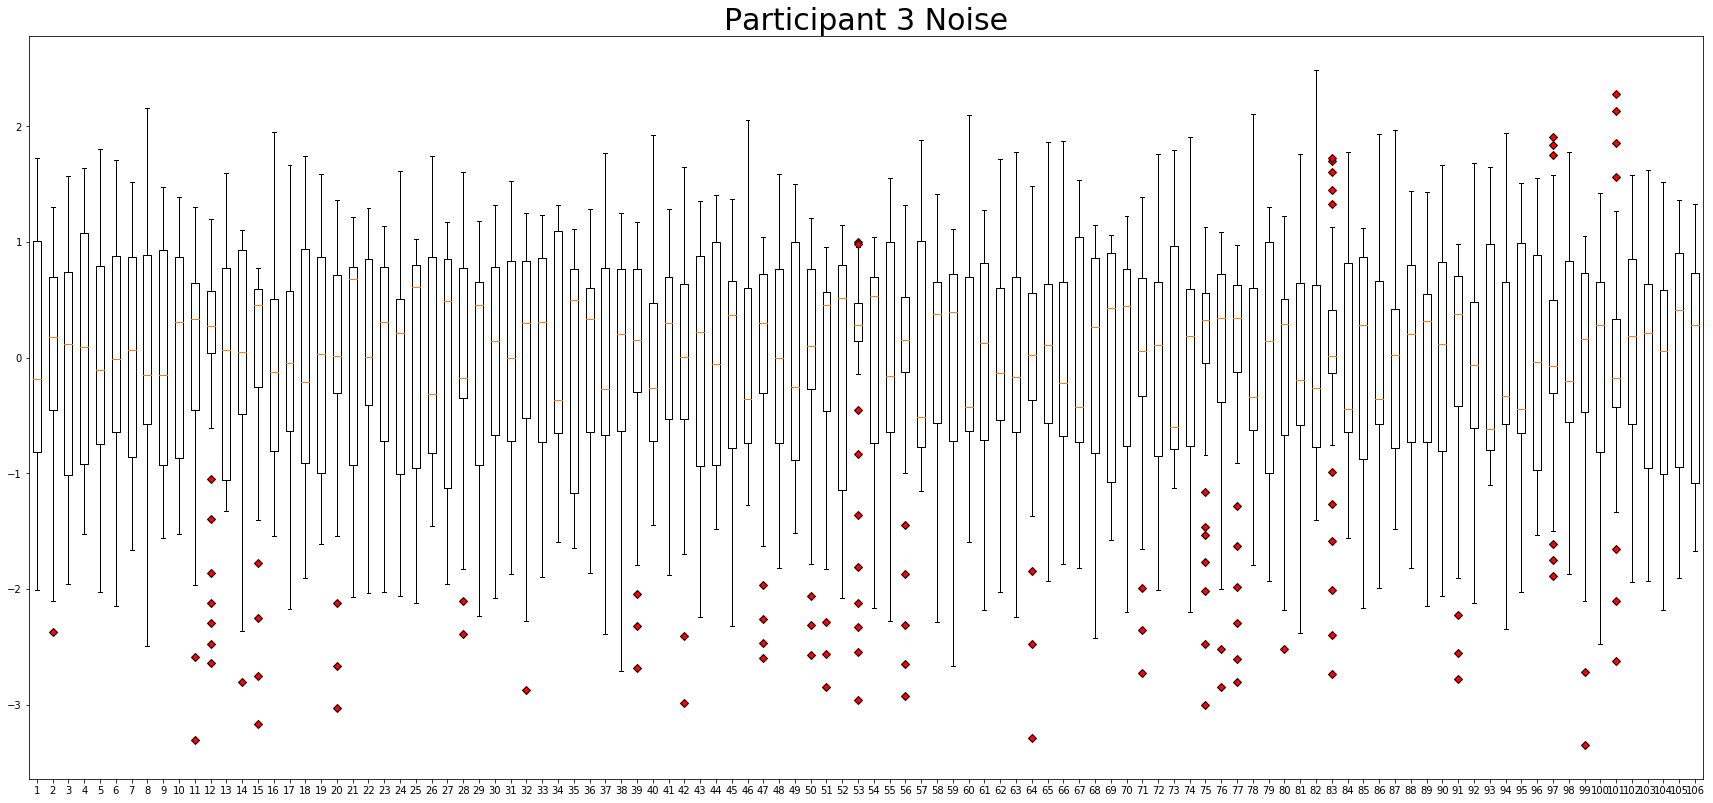

<Figure size 432x288 with 0 Axes>

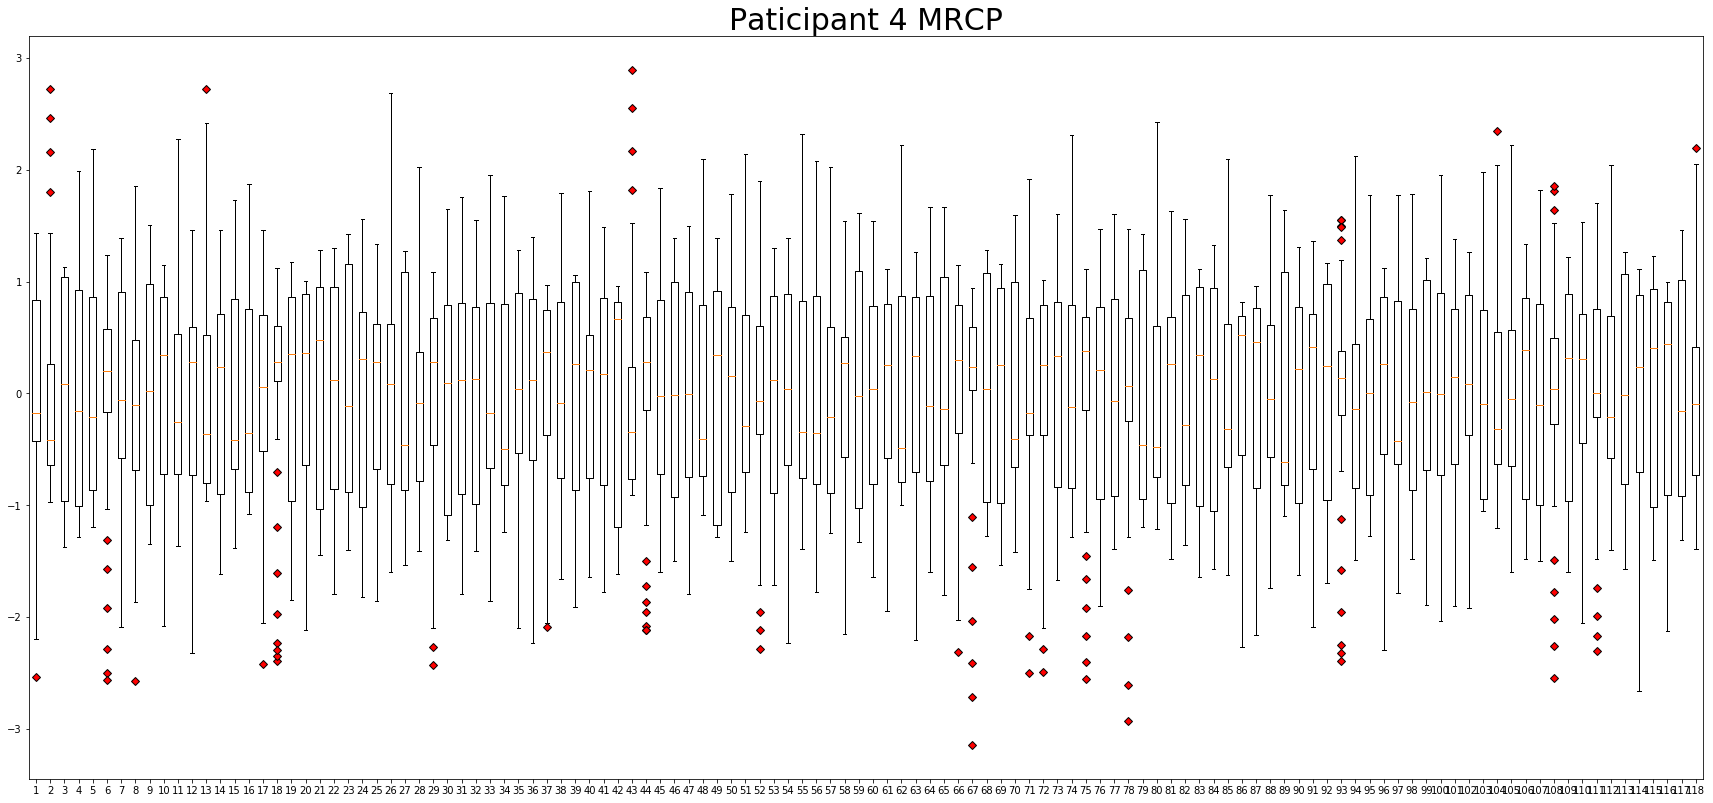

<Figure size 432x288 with 0 Axes>

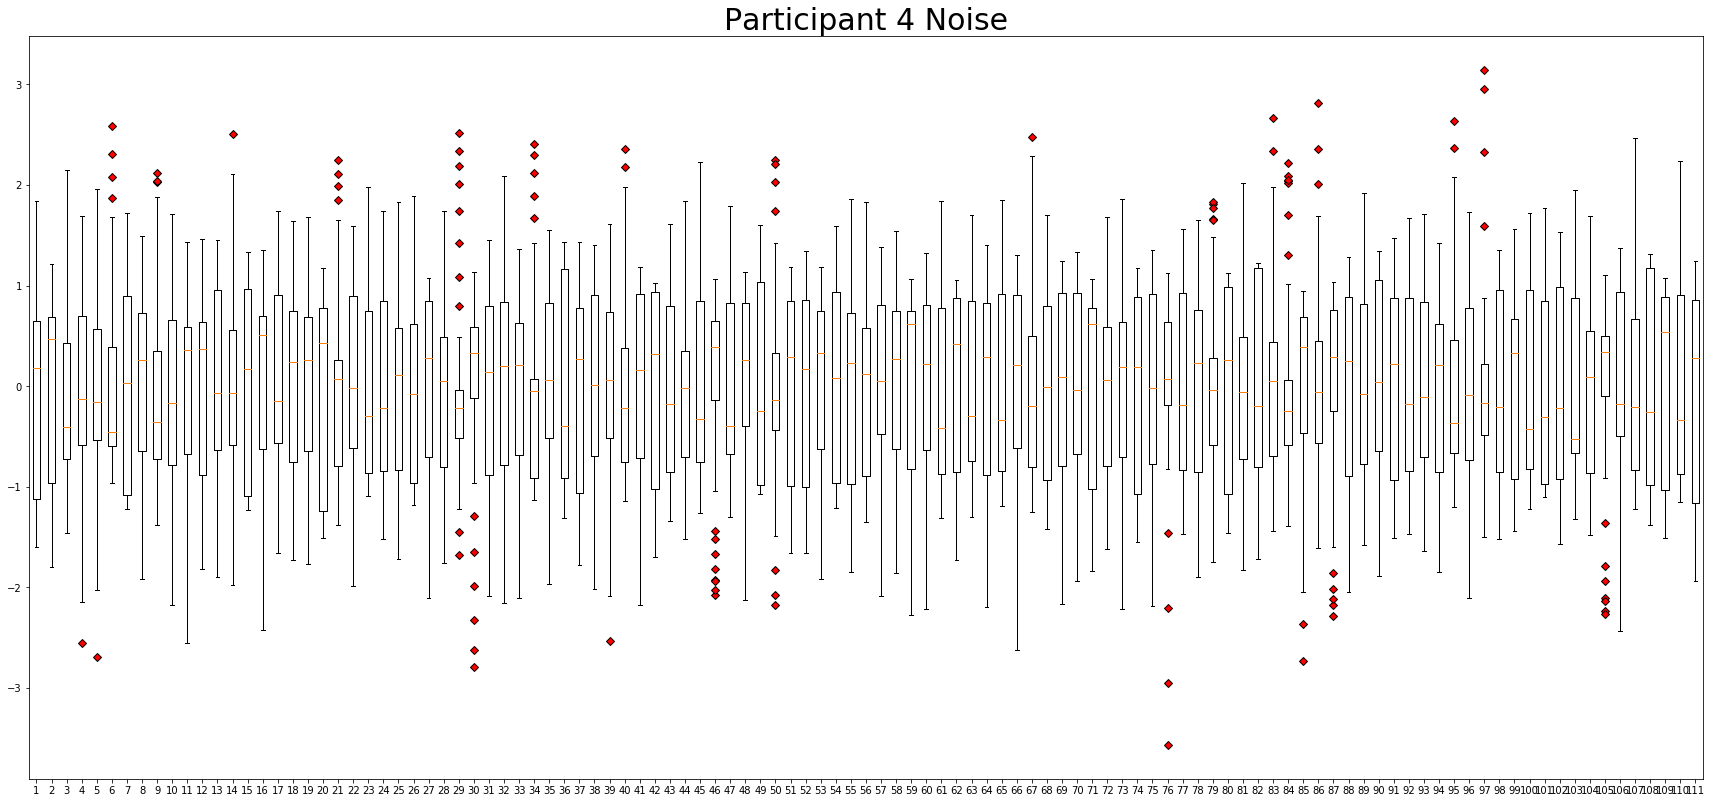

<Figure size 432x288 with 0 Axes>

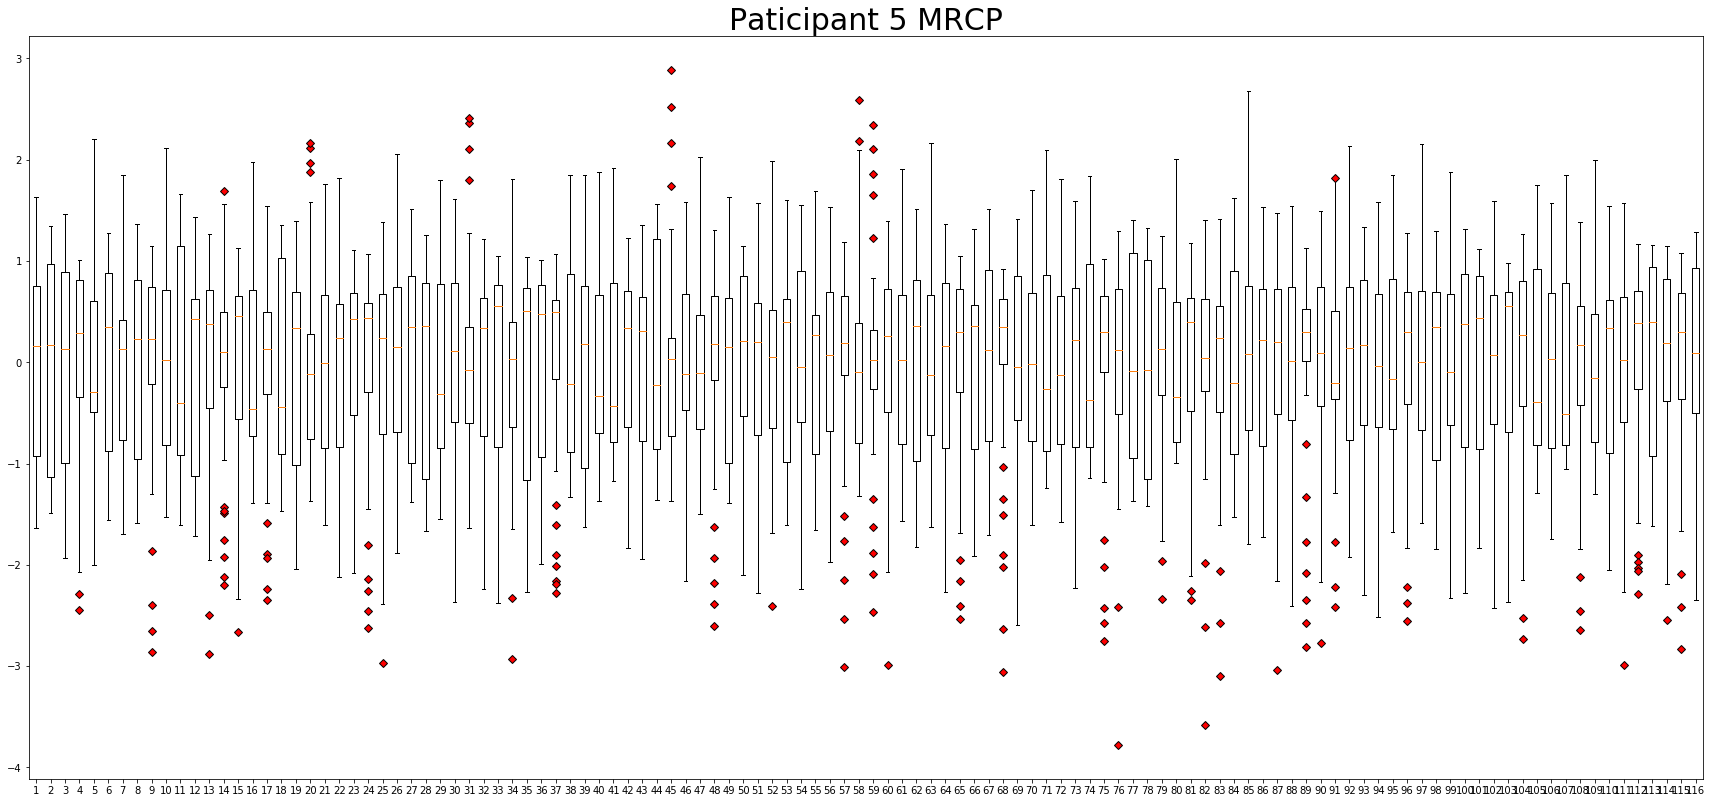

<Figure size 432x288 with 0 Axes>

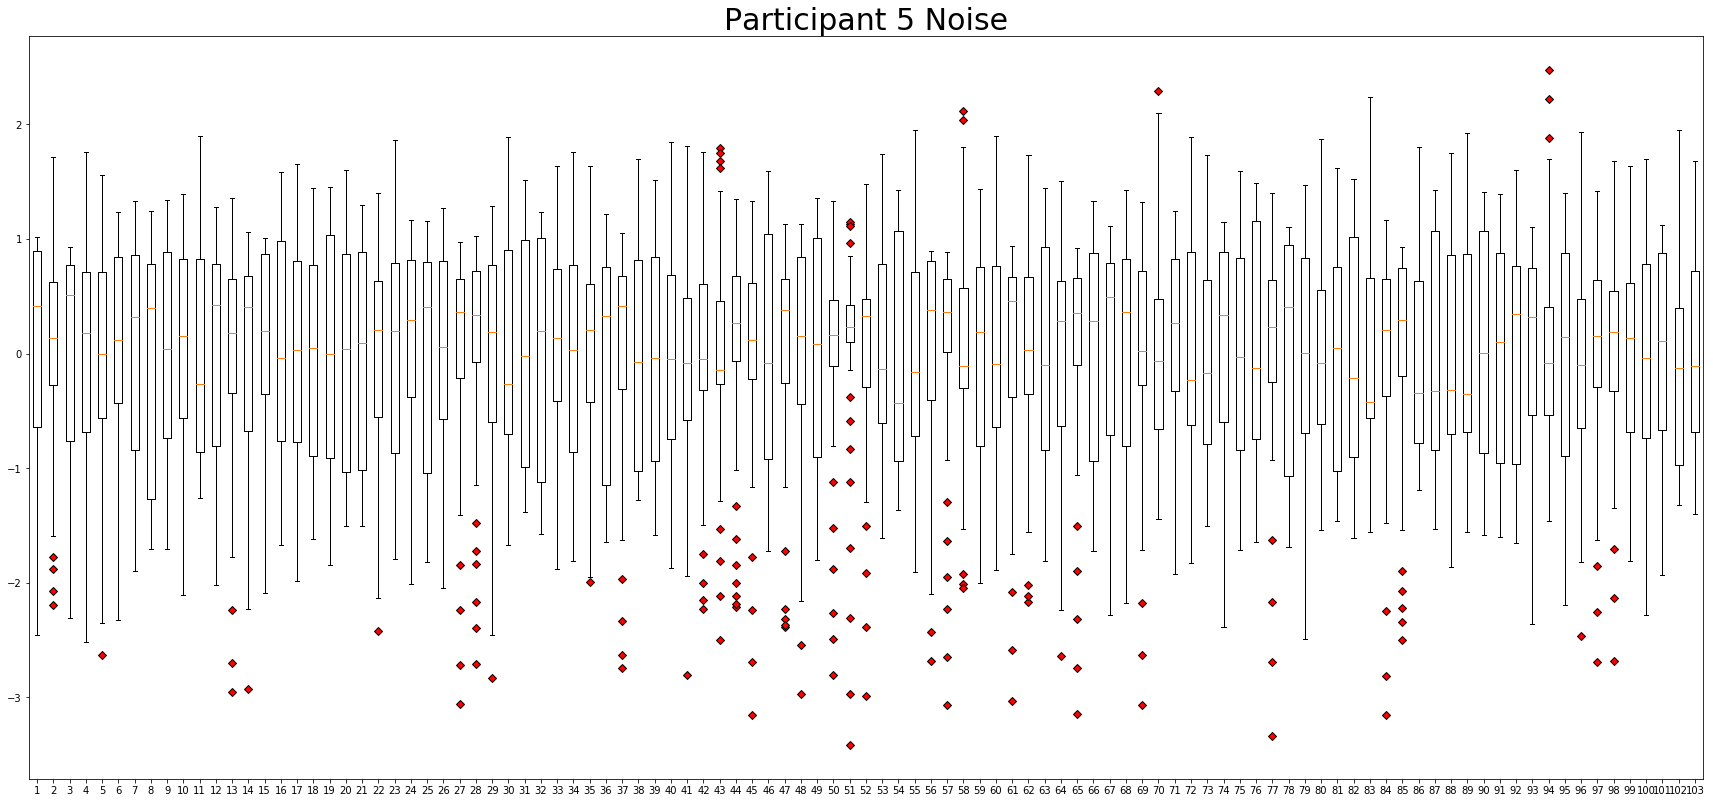

<Figure size 432x288 with 0 Axes>

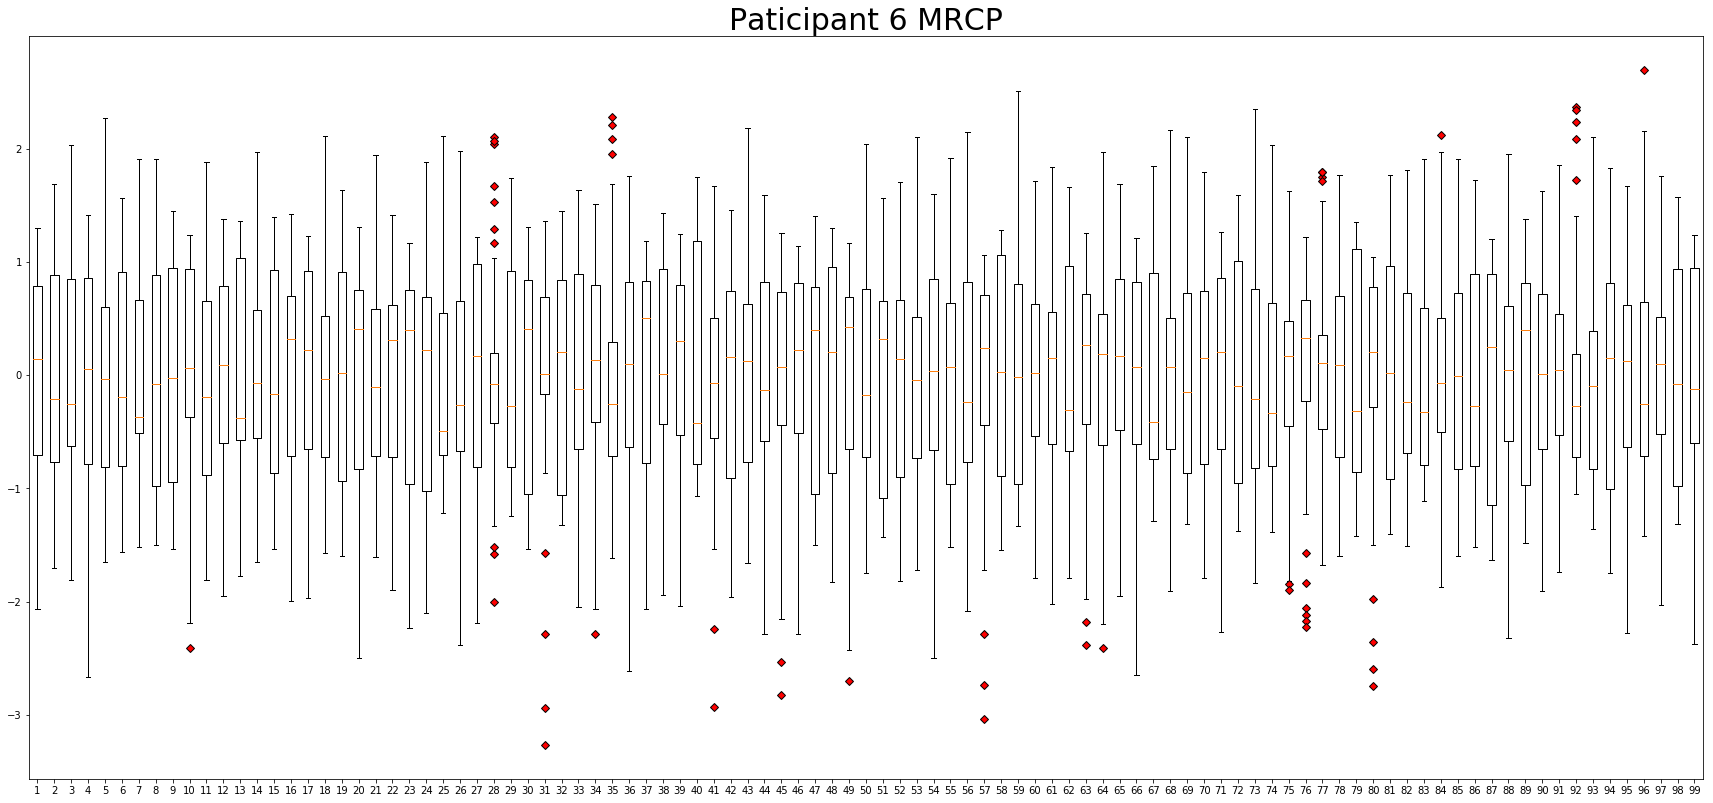

<Figure size 432x288 with 0 Axes>

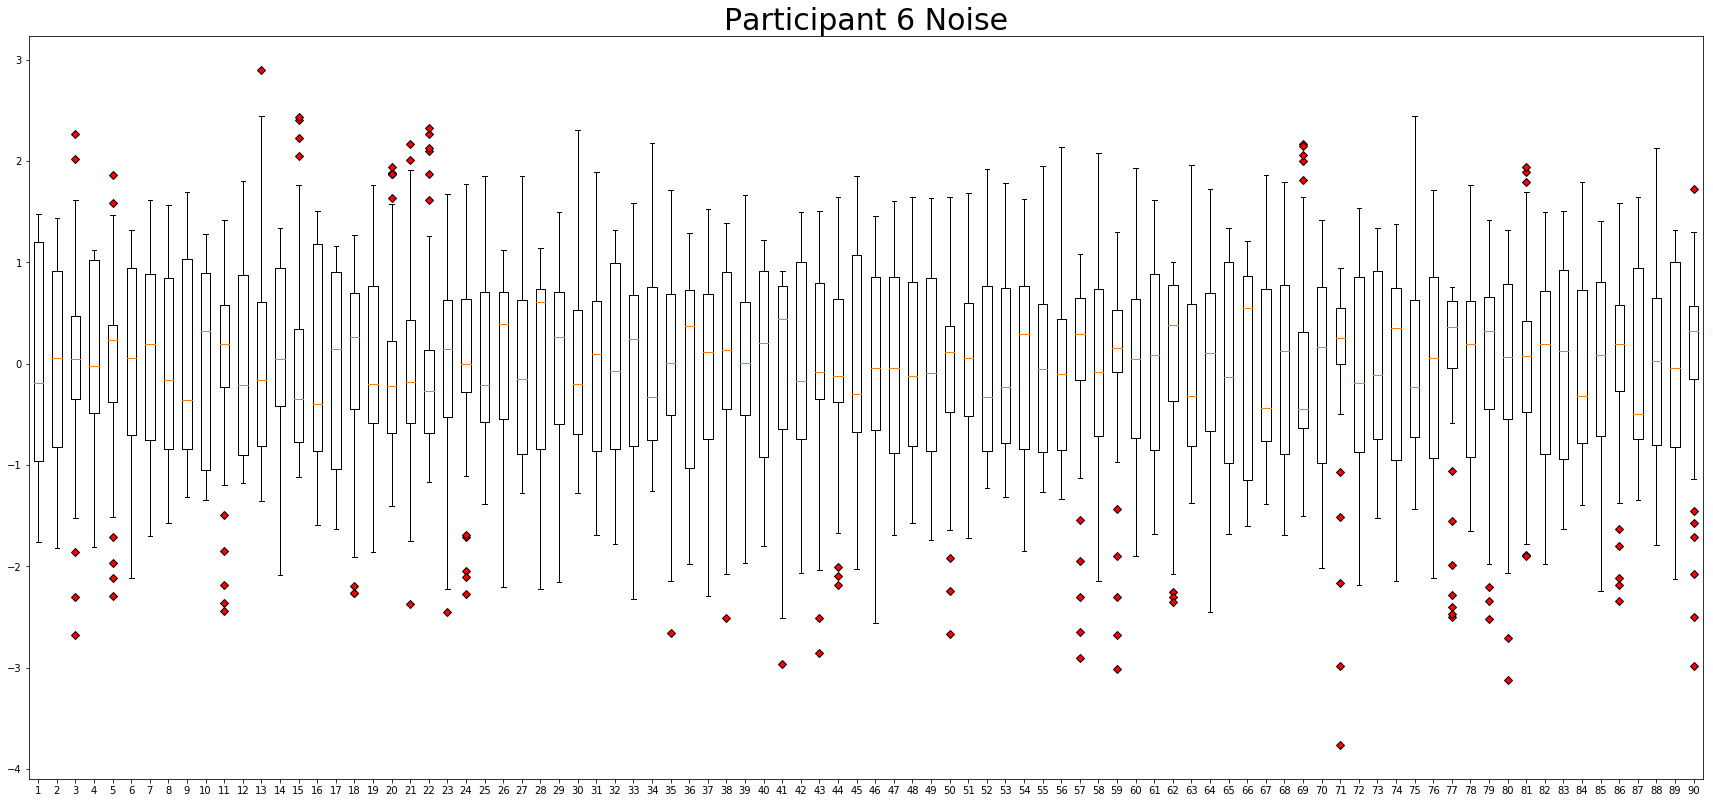

<Figure size 432x288 with 0 Axes>

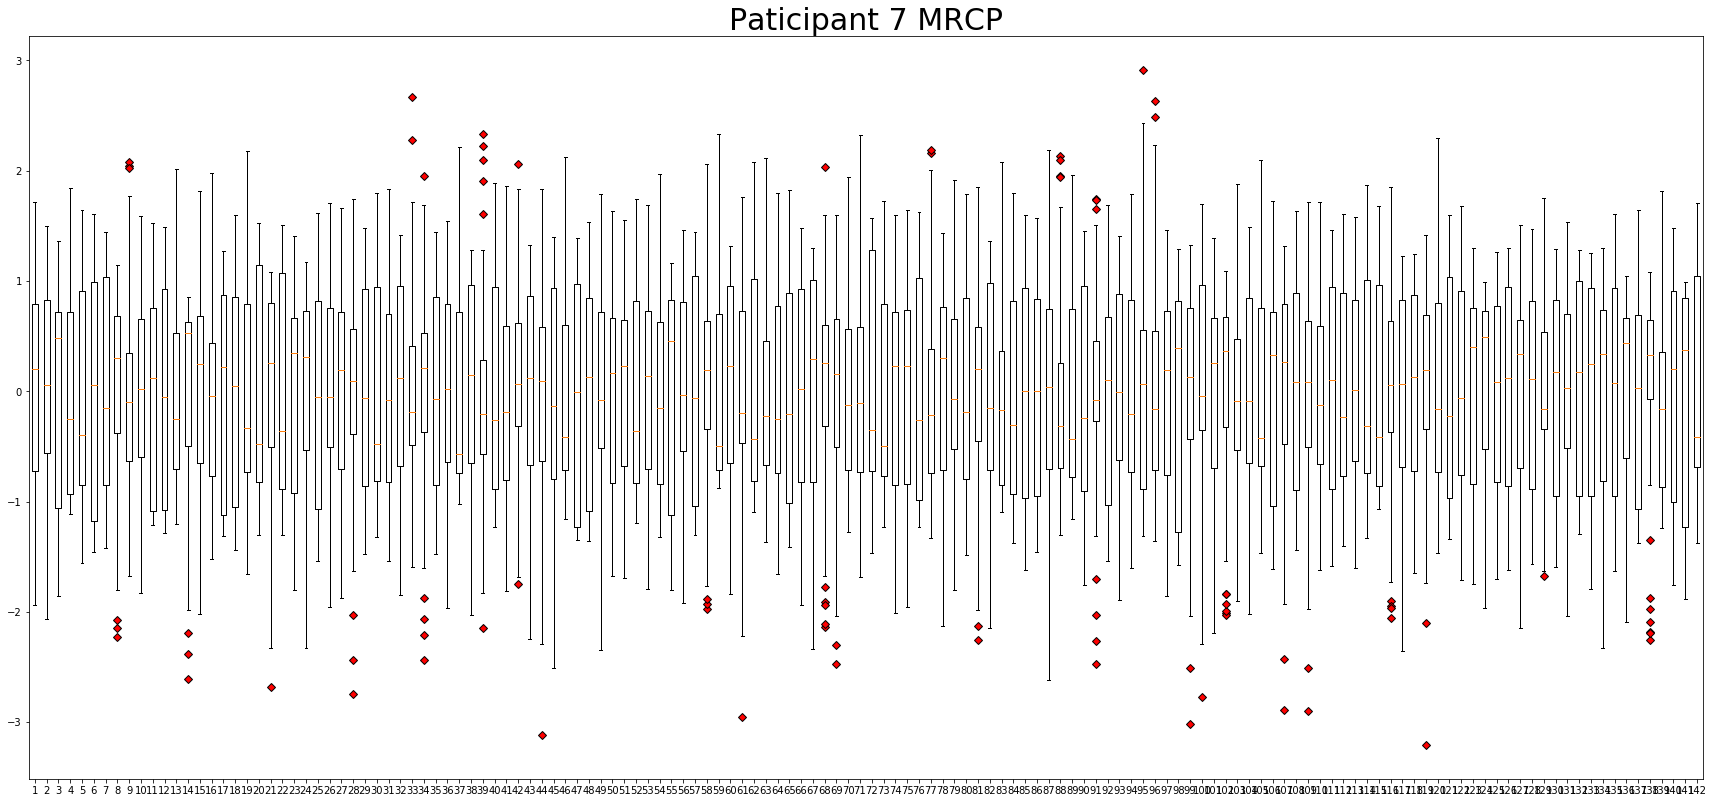

<Figure size 432x288 with 0 Axes>

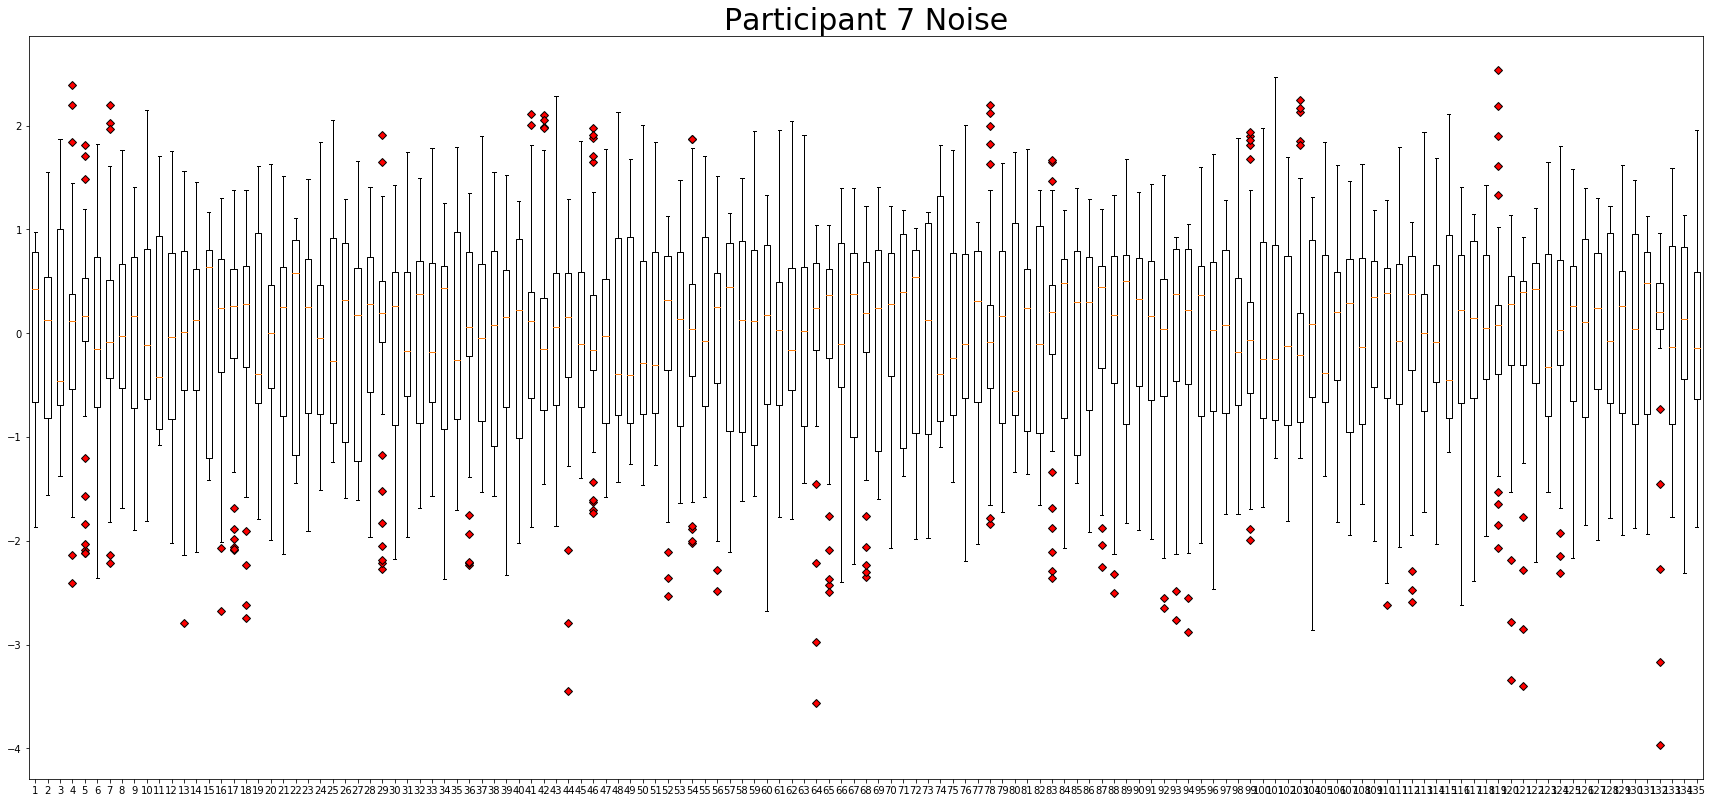

<Figure size 432x288 with 0 Axes>

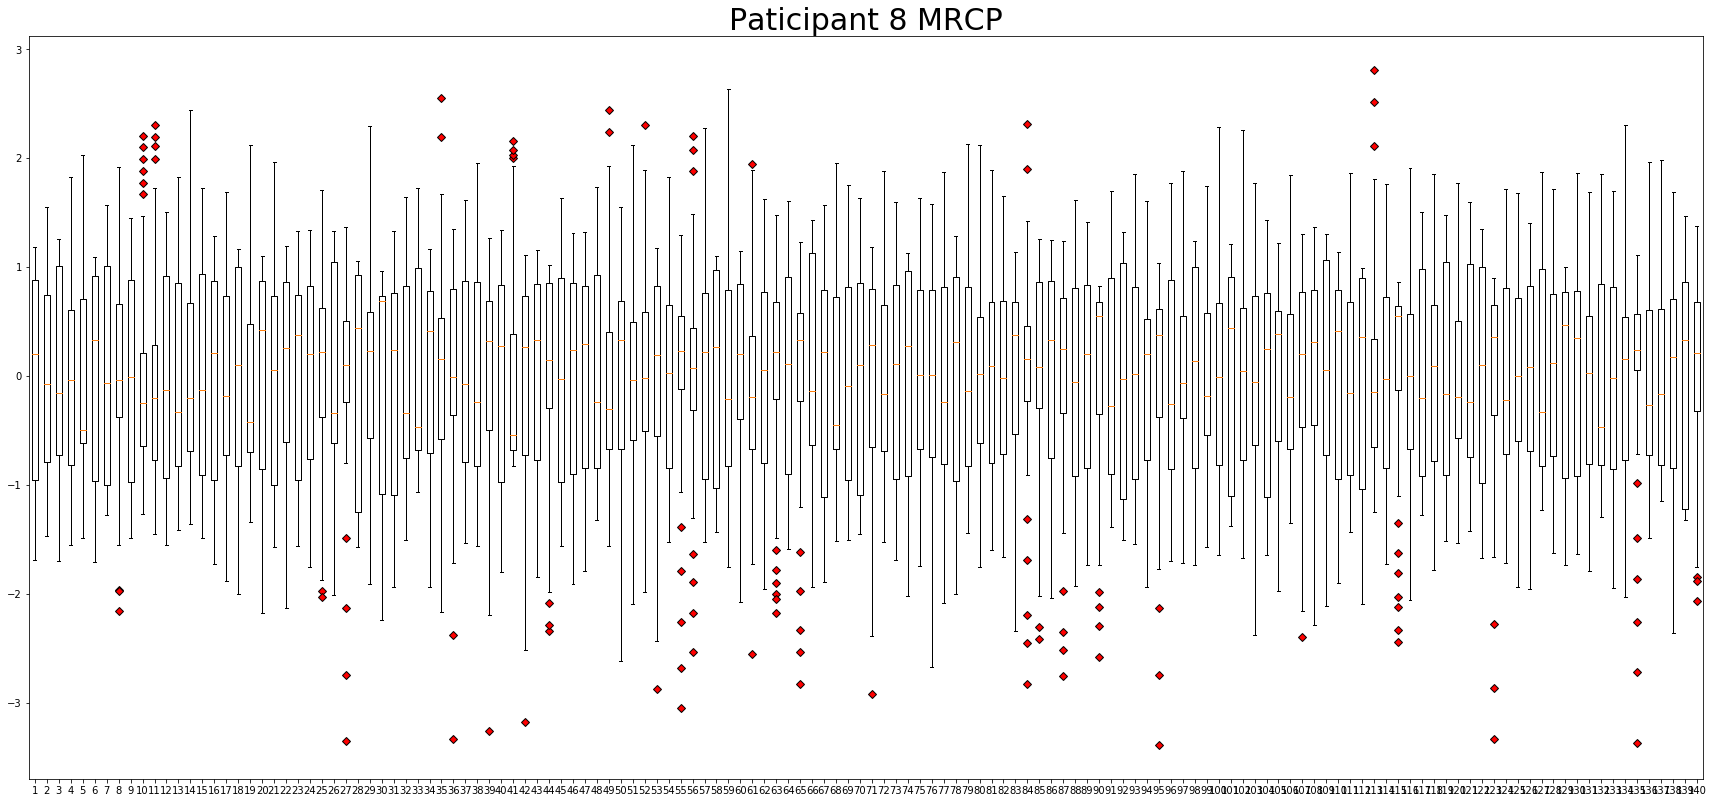

<Figure size 432x288 with 0 Axes>

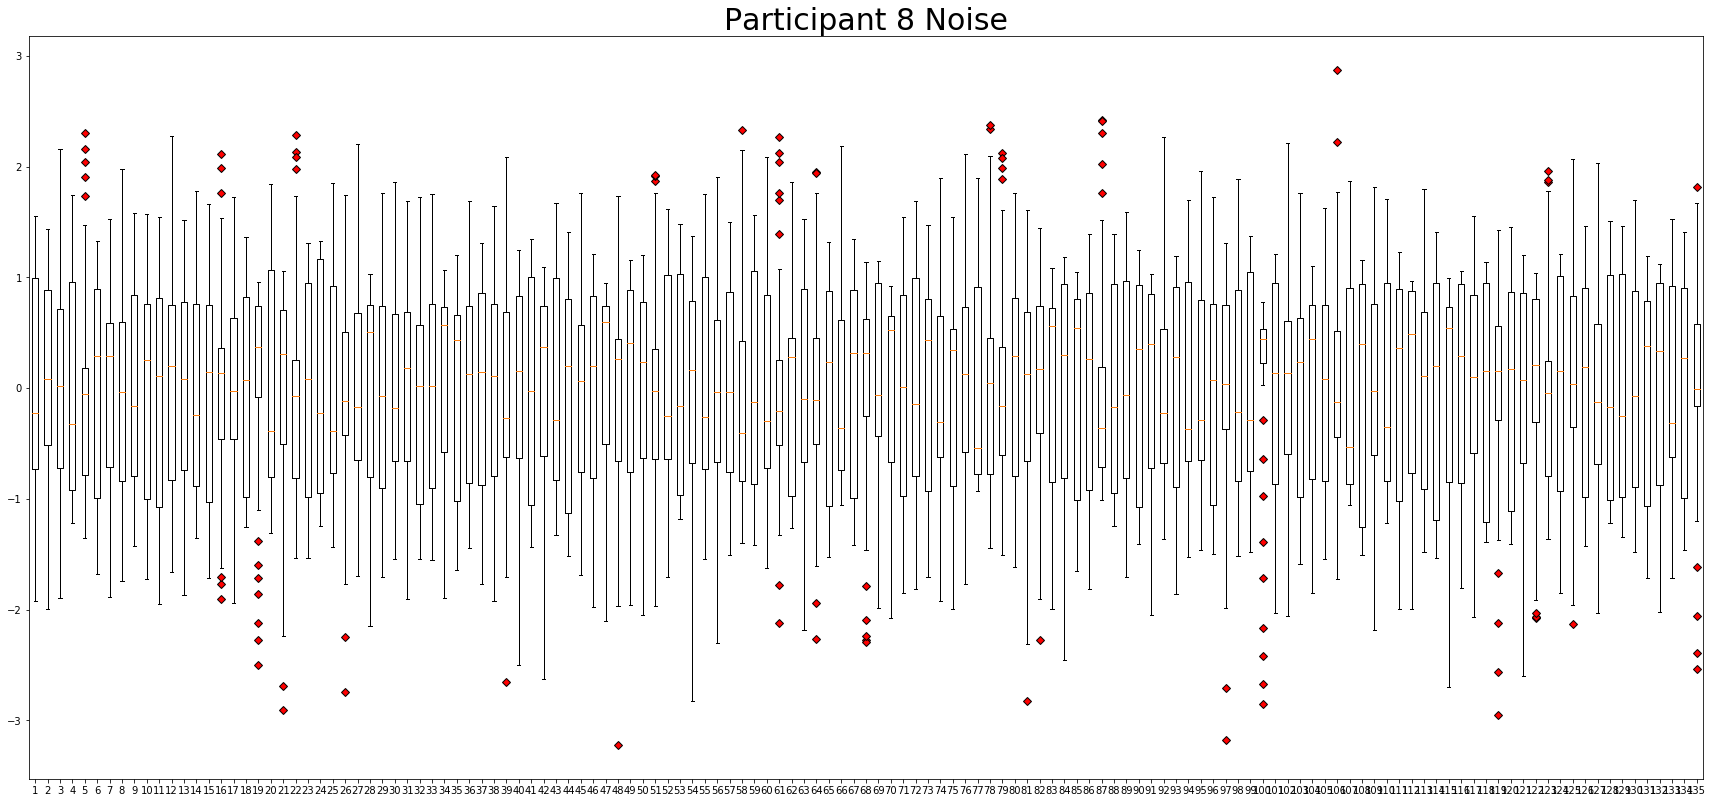

<Figure size 432x288 with 0 Axes>

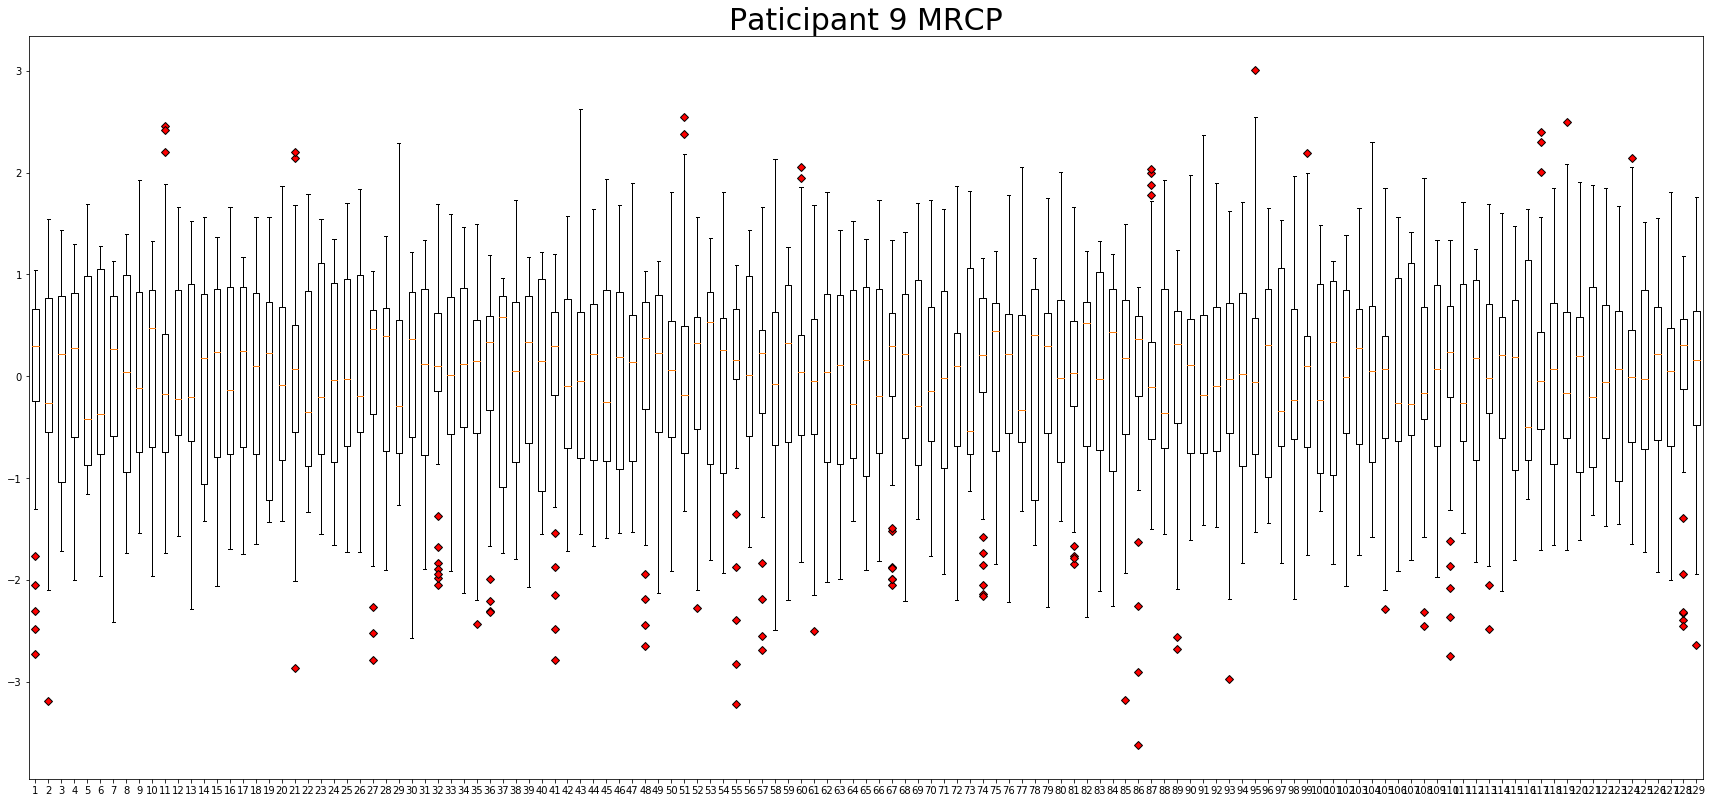

<Figure size 432x288 with 0 Axes>

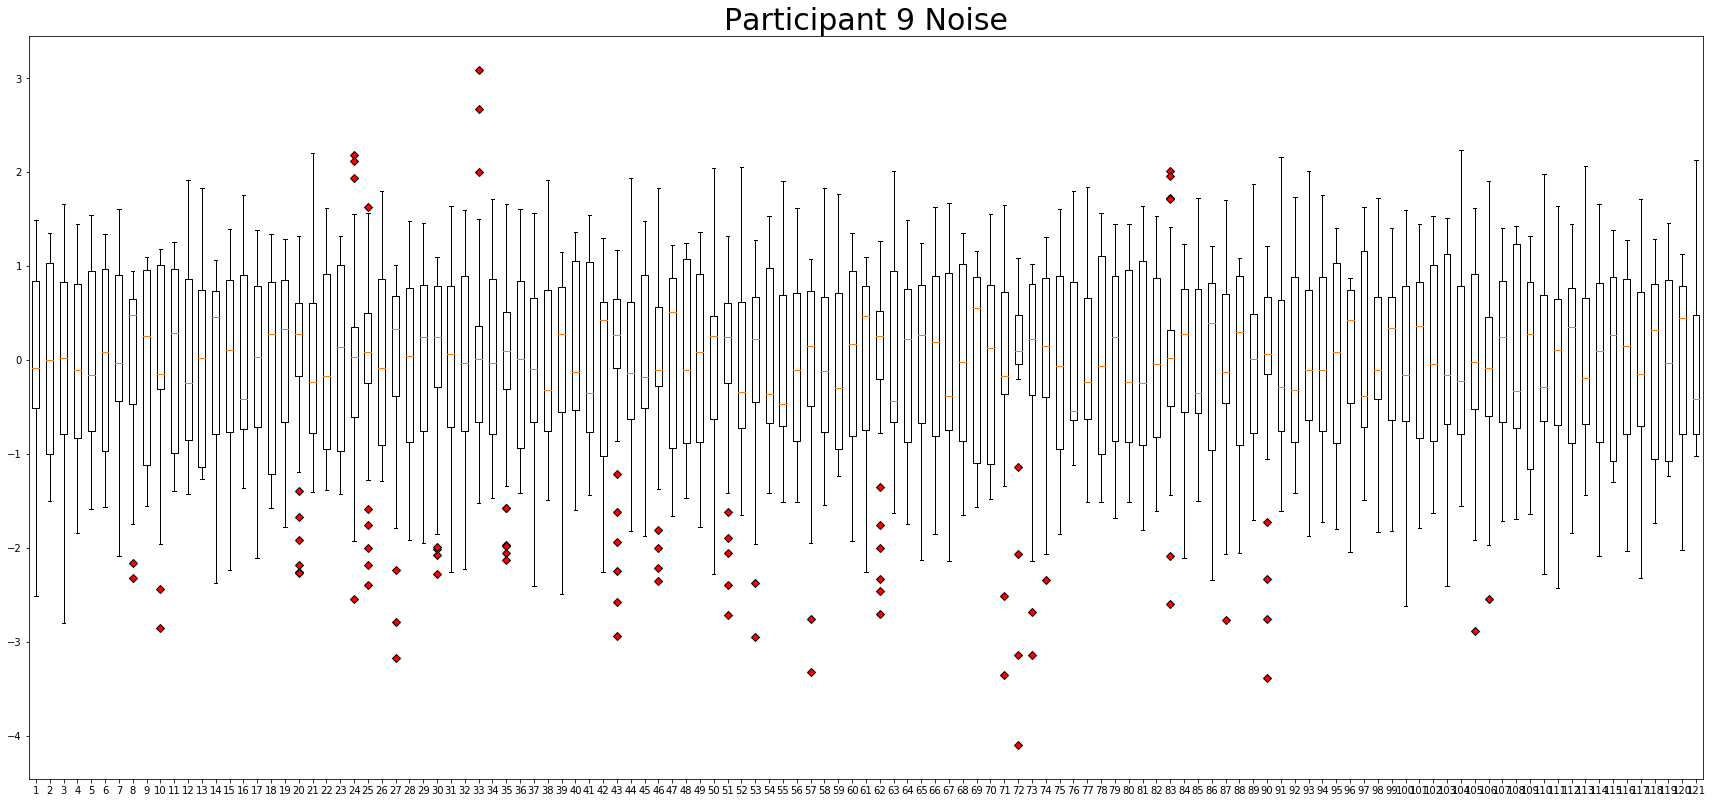

In [30]:
for par in range(1,10):
    data , results = read_all_lines('training data/participant_'+str(par)+'.txt')
    test_data , test_results = read_all_lines('test data/participant_'+str(par)+'.txt')

    mrcp_data = list()
    noise_data = list()
    mrcp_result = list()
    noise_result = list()

    for each_data, each_result in zip(data,results):
        if each_result == 'MRCP':
            mrcp_data.append(each_data)
            mrcp_result.append(each_result)
        else:
            noise_data.append(each_data)
            noise_result.append(each_result)

    box_plot(mrcp_data,'Paticipant ' + str(par) + ' MRCP')
    box_plot(noise_data,'Participant ' + str(par) + ' Noise')

#     accuracy,f1_score = score(test_data,test_results,mrcp_avg,noise_avg);
#     print('F1_score: ', f1_score)

In [57]:
for par in range(1,10):
    data , results = read_all_lines('training data/participant_'+str(par)+'.txt')
    test_data , test_results = read_all_lines('test data/participant_'+str(par)+'.txt')

    mrcp_data = list()
    noise_data = list()
    mrcp_result = list()
    noise_result = list()
    mrcp_max = -float('inf')
    noise_max = -float('inf')
    mrcp_min = float('inf')
    noise_min = float('inf')
    for each_data, each_result in zip(data,results):
        if each_result == 'MRCP':
            mrcp_data.append(each_data)
            mrcp_result.append(each_result)
            if max(each_data) > mrcp_max : mrcp_max = max(each_data)
            if min(each_data) < mrcp_min : mrcp_min = min(each_data)
        else:
            noise_data.append(each_data)
            noise_result.append(each_result)
            if max(each_data) > noise_max : noise_max = max(each_data)
            if min(each_data) < noise_min : noise_min = min(each_data)
            
    print('Participant ' + str(par))
    print('Max MRCP Value is ' + str(mrcp_max))
    print('Min MRCP Value is ' + str(mrcp_min))
    
    print('Max Noise Value is ' + str(noise_max))
    print('Min Noise Value is ' + str(noise_min))
    print('--------------------------------------------------------------------')

Participant 1
Max MRCP Value is 3.4139528125387626
Min MRCP Value is -3.918627335356729
Max Noise Value is 2.851012076716917
Min Noise Value is -3.033248828392967
--------------------------------------------------------------------
Participant 2
Max MRCP Value is 2.371777986028236
Min MRCP Value is -3.548811904796679
Max Noise Value is 3.794341152751434
Min Noise Value is -1.883920125343433
--------------------------------------------------------------------
Participant 3
Max MRCP Value is 2.7674749728611547
Min MRCP Value is -4.145459073792107
Max Noise Value is 2.490335972284105
Min Noise Value is -3.347718002653334
--------------------------------------------------------------------
Participant 4
Max MRCP Value is 2.8964001550575746
Min MRCP Value is -3.144496973830317
Max Noise Value is 3.1473069363980883
Min Noise Value is -3.5670469123879793
--------------------------------------------------------------------
Participant 5
Max MRCP Value is 2.8884658915923556
Min MRCP Value is -3

In [59]:
data , results = read_all_lines('training data/participant_'+str(2)+'.txt')
test_data , test_results = read_all_lines('test data/participant_'+str(2)+'.txt')

mrcp_data = list()
noise_data = list()
mrcp_result = list()
noise_result = list()

for each_data, each_result in zip(data,results):
    if each_result == 'MRCP':
        mrcp_data.append(each_data)
        mrcp_result.append(each_result)
    else:
        noise_data.append(each_data)
        noise_result.append(each_result)
        
noise_data[25]

array([ 3.79434115,  3.09007813,  2.3372601 ,  1.63152708,  1.00235306,
        0.48329404,  0.06965803, -0.26564998, -0.52175599, -0.691776  ,
       -0.768515  , -0.785461  , -0.737428  , -0.653553  , -0.56730899,
       -0.51951099, -0.51428399, -0.52866199, -0.54247099, -0.51466099,
       -0.44155399, -0.41024399, -0.40891999, -0.38843199, -0.36295899,
       -0.36234399, -0.36211999, -0.37061399, -0.40099299, -0.43450299,
       -0.43253299, -0.36376799, -0.25472998, -0.12273498, -0.00890998,
        0.05805203,  0.10266503,  0.09981403,  0.06839903,  0.02613803,
       -0.02718398])

In [63]:
np.mean(noise_data[25])

1.5993304241932513e-17